In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df, set_num):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        vc = data.loc[data['set'] == set_num, col].value_counts() / sum(data['set'] == set_num)
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data, 0)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

66
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'cate

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0425774
[100]	valid_0's binary_logloss: 0.0400447
[150]	valid_0's binary_logloss: 0.0388366
[200]	valid_0's binary_logloss: 0.0381382
[250]	valid_0's binary_logloss: 0.0376346
[300]	valid_0's binary_logloss: 0.0372854
[350]	valid_0's binary_logloss: 0.0368611
[400]	valid_0's binary_logloss: 0.0364991
[450]	valid_0's binary_logloss: 0.0362258
[500]	valid_0's binary_logloss: 0.0359198
[550]	valid_0's binary_logloss: 0.0356812
[600]	valid_0's binary_logloss: 0.0354347
[650]	valid_0's binary_logloss: 0.0352144
[700]	valid_0's binary_logloss: 0.0350228
[750]	valid_0's binary_logloss: 0.0348223
[800]	valid_0's binary_logloss: 0.0346211
[850]	valid_0's binary_logloss: 0.0344185
[900]	valid_0's binary_logloss: 0.034272
[950]	valid_0's binary_logloss: 0.0341216
[1000]	valid_0's binary_logloss: 0.0339775
[1050]	valid_0's binary_logloss: 0.0338322
[1100]	valid_0's binary_logloss: 0.0336842
[1150]	valid_0's binary_logloss: 0.0335601
[1200]	valid_0's binary_logloss:

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

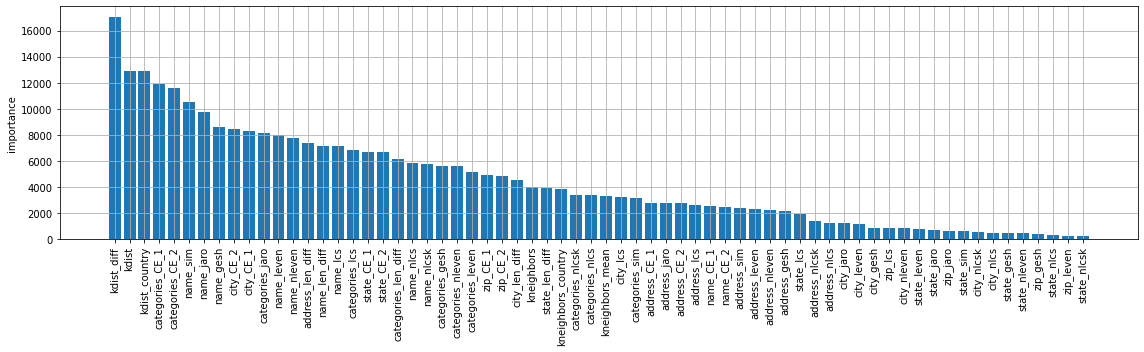

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data, 1)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-30 12:35:43,511] A new study created in memory with name: no-name-f4586d11-24e1-4274-a9b9-64f201e7e2c1
[I 2022-05-30 12:36:09,943] Trial 0 finished with value: 0.8251638404697239 and parameters: {'threshold': 0.2979967634058579}. Best is trial 0 with value: 0.8251638404697239.


CV: 0.825164


[I 2022-05-30 12:36:29,187] Trial 1 finished with value: 0.8289481932926089 and parameters: {'threshold': 0.35014464935569267}. Best is trial 1 with value: 0.8289481932926089.


CV: 0.828948


[I 2022-05-30 12:36:50,195] Trial 2 finished with value: 0.7945582430610267 and parameters: {'threshold': 0.1204607066871266}. Best is trial 1 with value: 0.8289481932926089.


CV: 0.794558


[I 2022-05-30 12:37:10,285] Trial 3 finished with value: 0.786551154469794 and parameters: {'threshold': 0.09954695464185126}. Best is trial 1 with value: 0.8289481932926089.


CV: 0.786551


[I 2022-05-30 12:37:30,599] Trial 4 finished with value: 0.8209669479746781 and parameters: {'threshold': 0.25563708070645497}. Best is trial 1 with value: 0.8289481932926089.


CV: 0.820967


[I 2022-05-30 12:37:49,304] Trial 5 finished with value: 0.8316515692969915 and parameters: {'threshold': 0.7616814729303019}. Best is trial 5 with value: 0.8316515692969915.


CV: 0.831652


[I 2022-05-30 12:38:08,782] Trial 6 finished with value: 0.8330137745565711 and parameters: {'threshold': 0.7369485384474983}. Best is trial 6 with value: 0.8330137745565711.


CV: 0.833014


[I 2022-05-30 12:38:27,500] Trial 7 finished with value: 0.7754860156701613 and parameters: {'threshold': 0.9787372878256203}. Best is trial 6 with value: 0.8330137745565711.


CV: 0.775486


[I 2022-05-30 12:38:49,773] Trial 8 finished with value: 0.8333522828809169 and parameters: {'threshold': 0.7291693106633949}. Best is trial 8 with value: 0.8333522828809169.


CV: 0.833352


[I 2022-05-30 12:39:09,201] Trial 9 finished with value: 0.8106424474620638 and parameters: {'threshold': 0.919119238404794}. Best is trial 8 with value: 0.8333522828809169.


CV: 0.810642


[I 2022-05-30 12:39:28,298] Trial 10 finished with value: 0.8357747324050389 and parameters: {'threshold': 0.5803130804517536}. Best is trial 10 with value: 0.8357747324050389.


CV: 0.835775


[I 2022-05-30 12:39:48,146] Trial 11 finished with value: 0.835757025727911 and parameters: {'threshold': 0.5615097509306841}. Best is trial 10 with value: 0.8357747324050389.


CV: 0.835757


[I 2022-05-30 12:40:07,222] Trial 12 finished with value: 0.8349860738619932 and parameters: {'threshold': 0.5016875388539863}. Best is trial 10 with value: 0.8357747324050389.


CV: 0.834986


[I 2022-05-30 12:40:27,219] Trial 13 finished with value: 0.8351217489459536 and parameters: {'threshold': 0.5106057887648421}. Best is trial 10 with value: 0.8357747324050389.


CV: 0.835122


[I 2022-05-30 12:40:47,128] Trial 14 finished with value: 0.8358388693623108 and parameters: {'threshold': 0.6077273089803945}. Best is trial 14 with value: 0.8358388693623108.


CV: 0.835839


[I 2022-05-30 12:41:06,113] Trial 15 finished with value: 0.835723772156216 and parameters: {'threshold': 0.6232132867018587}. Best is trial 14 with value: 0.8358388693623108.


CV: 0.835724


[I 2022-05-30 12:41:26,133] Trial 16 finished with value: 0.832540710632235 and parameters: {'threshold': 0.4186502065353072}. Best is trial 14 with value: 0.8358388693623108.


CV: 0.832541


[I 2022-05-30 12:41:45,924] Trial 17 finished with value: 0.8352176352109515 and parameters: {'threshold': 0.6626958950311992}. Best is trial 14 with value: 0.8358388693623108.


CV: 0.835218


[I 2022-05-30 12:42:04,433] Trial 18 finished with value: 0.8259814003613968 and parameters: {'threshold': 0.8354225662134508}. Best is trial 14 with value: 0.8358388693623108.


CV: 0.825981


[I 2022-05-30 12:42:24,580] Trial 19 finished with value: 0.8324023934015541 and parameters: {'threshold': 0.41561081389423427}. Best is trial 14 with value: 0.8358388693623108.


CV: 0.832402


[I 2022-05-30 12:42:43,433] Trial 20 finished with value: 0.8358412330729631 and parameters: {'threshold': 0.6126030282629716}. Best is trial 20 with value: 0.8358412330729631.


CV: 0.835841


[I 2022-05-30 12:43:03,914] Trial 21 finished with value: 0.8358741647880689 and parameters: {'threshold': 0.6057252426735704}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835874


[I 2022-05-30 12:43:23,801] Trial 22 finished with value: 0.8349918433695123 and parameters: {'threshold': 0.6740525751115087}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.834992


[I 2022-05-30 12:43:42,392] Trial 23 finished with value: 0.8298444273963435 and parameters: {'threshold': 0.7917028766587451}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.829844


[I 2022-05-30 12:44:02,276] Trial 24 finished with value: 0.8336885948547039 and parameters: {'threshold': 0.45322361779630305}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.833689


[I 2022-05-30 12:44:21,698] Trial 25 finished with value: 0.8244491762394343 and parameters: {'threshold': 0.8478394912571439}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.824449


[I 2022-05-30 12:44:40,603] Trial 26 finished with value: 0.8358614934332312 and parameters: {'threshold': 0.5982036272970177}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835861


[I 2022-05-30 12:45:00,499] Trial 27 finished with value: 0.8354894425101972 and parameters: {'threshold': 0.5446920604192909}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835489


[I 2022-05-30 12:45:20,091] Trial 28 finished with value: 0.8347919377400719 and parameters: {'threshold': 0.6847627397698443}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.834792


[I 2022-05-30 12:45:40,297] Trial 29 finished with value: 0.8265233933709534 and parameters: {'threshold': 0.31463403089841124}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.826523


[I 2022-05-30 12:46:00,893] Trial 30 finished with value: 0.8120914536453847 and parameters: {'threshold': 0.19253044037016503}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.812091


[I 2022-05-30 12:46:25,498] Trial 31 finished with value: 0.5438895983708164 and parameters: {'threshold': 0.0031250603271114064}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.543890


[I 2022-05-30 12:46:45,228] Trial 32 finished with value: 0.8358389573589555 and parameters: {'threshold': 0.6130357190113904}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835839


[I 2022-05-30 12:47:05,293] Trial 33 finished with value: 0.833770878683785 and parameters: {'threshold': 0.455154628082834}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.833771


[I 2022-05-30 12:47:23,988] Trial 34 finished with value: 0.835728892249925 and parameters: {'threshold': 0.6226466099601166}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835729


[I 2022-05-30 12:47:44,922] Trial 35 finished with value: 0.829400212430014 and parameters: {'threshold': 0.3583266556998159}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.829400


[I 2022-05-30 12:48:03,724] Trial 36 finished with value: 0.8348751564729274 and parameters: {'threshold': 0.6819876838633504}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.834875


[I 2022-05-30 12:48:23,619] Trial 37 finished with value: 0.8357340875209792 and parameters: {'threshold': 0.5577901978175049}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835734


[I 2022-05-30 12:48:43,548] Trial 38 finished with value: 0.8335869135590978 and parameters: {'threshold': 0.72366501426405}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.833587


[I 2022-05-30 12:49:03,440] Trial 39 finished with value: 0.8286266230707855 and parameters: {'threshold': 0.806124080244079}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.828627


[I 2022-05-30 12:49:21,933] Trial 40 finished with value: 0.8140514749731637 and parameters: {'threshold': 0.9060961746157014}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.814051


[I 2022-05-30 12:49:42,058] Trial 41 finished with value: 0.8358445171942935 and parameters: {'threshold': 0.609721021549813}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835845


[I 2022-05-30 12:50:02,107] Trial 42 finished with value: 0.8356572888665268 and parameters: {'threshold': 0.6359578428169758}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835657


[I 2022-05-30 12:50:21,422] Trial 43 finished with value: 0.8353011605612531 and parameters: {'threshold': 0.5233496524499412}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835301


[I 2022-05-30 12:50:41,420] Trial 44 finished with value: 0.8358437075161204 and parameters: {'threshold': 0.5940477719432755}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835844


[I 2022-05-30 12:51:01,357] Trial 45 finished with value: 0.8334909283495435 and parameters: {'threshold': 0.7265852272209625}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.833491


[I 2022-05-30 12:51:21,684] Trial 46 finished with value: 0.8344546839840247 and parameters: {'threshold': 0.47667499981211287}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.834455


[I 2022-05-30 12:51:40,782] Trial 47 finished with value: 0.8358013556312041 and parameters: {'threshold': 0.582881651328293}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835801


[I 2022-05-30 12:52:01,903] Trial 48 finished with value: 0.8315044182971181 and parameters: {'threshold': 0.39673203023849546}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.831504


[I 2022-05-30 12:52:21,856] Trial 49 finished with value: 0.8358096430896752 and parameters: {'threshold': 0.5834174123039787}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835810


[I 2022-05-30 12:52:41,614] Trial 50 finished with value: 0.8317405983215934 and parameters: {'threshold': 0.7603906518739917}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.831741


[I 2022-05-30 12:53:00,661] Trial 51 finished with value: 0.835466833204986 and parameters: {'threshold': 0.644163144502385}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835467


[I 2022-05-30 12:53:20,689] Trial 52 finished with value: 0.8358527397393264 and parameters: {'threshold': 0.5950420921653958}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835853


[I 2022-05-30 12:53:40,593] Trial 53 finished with value: 0.8353046350523695 and parameters: {'threshold': 0.5252215761980057}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835305


[I 2022-05-30 12:53:59,578] Trial 54 finished with value: 0.834296911452851 and parameters: {'threshold': 0.7031861551044163}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.834297


[I 2022-05-30 12:54:19,610] Trial 55 finished with value: 0.8357812482776659 and parameters: {'threshold': 0.5805193523888545}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835781


[I 2022-05-30 12:54:39,589] Trial 56 finished with value: 0.8353574582608972 and parameters: {'threshold': 0.6555061597751829}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835357


[I 2022-05-30 12:54:59,681] Trial 57 finished with value: 0.835284758762787 and parameters: {'threshold': 0.5212170195673368}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835285


[I 2022-05-30 12:55:19,756] Trial 58 finished with value: 0.8342925198586669 and parameters: {'threshold': 0.471484521276398}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.834293


[I 2022-05-30 12:55:38,256] Trial 59 finished with value: 0.8311724637758254 and parameters: {'threshold': 0.7695377602979936}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.831172


[I 2022-05-30 12:55:58,276] Trial 60 finished with value: 0.8358717980673074 and parameters: {'threshold': 0.6003603493509407}. Best is trial 21 with value: 0.8358741647880689.


CV: 0.835872


[I 2022-05-30 12:56:18,636] Trial 61 finished with value: 0.8358770724758343 and parameters: {'threshold': 0.6005526066613522}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835877


[I 2022-05-30 12:56:37,581] Trial 62 finished with value: 0.8355320148040772 and parameters: {'threshold': 0.5469455840890821}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835532


[I 2022-05-30 12:56:57,573] Trial 63 finished with value: 0.8348621670428805 and parameters: {'threshold': 0.4953913504667523}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.834862


[I 2022-05-30 12:57:17,392] Trial 64 finished with value: 0.8358334566877313 and parameters: {'threshold': 0.5891420201344402}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835833


[I 2022-05-30 12:57:36,069] Trial 65 finished with value: 0.8344045049561941 and parameters: {'threshold': 0.6988299910015394}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.834405


[I 2022-05-30 12:57:55,700] Trial 66 finished with value: 0.8353581257158513 and parameters: {'threshold': 0.6542099419202416}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835358


[I 2022-05-30 12:58:15,483] Trial 67 finished with value: 0.8358452196832118 and parameters: {'threshold': 0.6097106813020847}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835845


[I 2022-05-30 12:58:34,420] Trial 68 finished with value: 0.8356484076937953 and parameters: {'threshold': 0.5544182460227313}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835648


[I 2022-05-30 12:58:54,373] Trial 69 finished with value: 0.832899078987149 and parameters: {'threshold': 0.42857008054698664}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.832899


[I 2022-05-30 12:59:14,056] Trial 70 finished with value: 0.8357322673511479 and parameters: {'threshold': 0.622895131957931}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835732


[I 2022-05-30 12:59:33,850] Trial 71 finished with value: 0.8358328515327879 and parameters: {'threshold': 0.6075620476502158}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835833


[I 2022-05-30 12:59:52,601] Trial 72 finished with value: 0.8349771836806926 and parameters: {'threshold': 0.6747259446467736}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.834977


[I 2022-05-30 13:00:12,372] Trial 73 finished with value: 0.8357919504151988 and parameters: {'threshold': 0.5644259984213914}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835792


[I 2022-05-30 13:00:34,147] Trial 74 finished with value: 0.8349514796105394 and parameters: {'threshold': 0.4997955782405924}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.834951


[I 2022-05-30 13:00:54,160] Trial 75 finished with value: 0.8358490394737782 and parameters: {'threshold': 0.5937868188930124}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835849


[I 2022-05-30 13:01:14,290] Trial 76 finished with value: 0.8355121900152664 and parameters: {'threshold': 0.6426977421998983}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835512


[I 2022-05-30 13:01:33,484] Trial 77 finished with value: 0.8354188510120968 and parameters: {'threshold': 0.539777989495545}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835419


[I 2022-05-30 13:01:53,396] Trial 78 finished with value: 0.8341307798947302 and parameters: {'threshold': 0.7073154415034061}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.834131


[I 2022-05-30 13:02:12,277] Trial 79 finished with value: 0.8325756675535629 and parameters: {'threshold': 0.7470384287919787}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.832576


[I 2022-05-30 13:02:32,302] Trial 80 finished with value: 0.835841224023787 and parameters: {'threshold': 0.6085228471654345}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835841


[I 2022-05-30 13:02:52,421] Trial 81 finished with value: 0.8358548155231483 and parameters: {'threshold': 0.5948408033316471}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835855


[I 2022-05-30 13:03:11,650] Trial 82 finished with value: 0.8357637393181041 and parameters: {'threshold': 0.562902979309219}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835764


[I 2022-05-30 13:03:31,505] Trial 83 finished with value: 0.8356968706510497 and parameters: {'threshold': 0.6294836604756724}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835697


[I 2022-05-30 13:03:51,260] Trial 84 finished with value: 0.8350669507316126 and parameters: {'threshold': 0.6686516903603805}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835067


[I 2022-05-30 13:04:10,216] Trial 85 finished with value: 0.8358758554983411 and parameters: {'threshold': 0.6004800284835803}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835876


[I 2022-05-30 13:04:30,010] Trial 86 finished with value: 0.8353878077712452 and parameters: {'threshold': 0.5355578519004356}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835388


[I 2022-05-30 13:04:49,934] Trial 87 finished with value: 0.8347378695004309 and parameters: {'threshold': 0.4893853721224922}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.834738


[I 2022-05-30 13:05:09,812] Trial 88 finished with value: 0.8358470732291571 and parameters: {'threshold': 0.5925319535928923}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835847


[I 2022-05-30 13:05:29,592] Trial 89 finished with value: 0.8358102447561608 and parameters: {'threshold': 0.5666279600037069}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835810


[I 2022-05-30 13:05:49,796] Trial 90 finished with value: 0.8335435555985645 and parameters: {'threshold': 0.44927042173999115}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.833544


[I 2022-05-30 13:06:09,126] Trial 91 finished with value: 0.8358618302470165 and parameters: {'threshold': 0.5954226038030674}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835862


[I 2022-05-30 13:06:29,341] Trial 92 finished with value: 0.8358630010618803 and parameters: {'threshold': 0.5953986583505918}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835863


[I 2022-05-30 13:06:49,089] Trial 93 finished with value: 0.8356066707159897 and parameters: {'threshold': 0.637911006231962}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835607


[I 2022-05-30 13:07:10,010] Trial 94 finished with value: 0.8351145895755359 and parameters: {'threshold': 0.5126477757558261}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835115


[I 2022-05-30 13:07:29,948] Trial 95 finished with value: 0.8346853542265905 and parameters: {'threshold': 0.6899293524007277}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.834685


[I 2022-05-30 13:07:49,863] Trial 96 finished with value: 0.8353728504482612 and parameters: {'threshold': 0.6536882470460775}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835373


[I 2022-05-30 13:08:08,958] Trial 97 finished with value: 0.8357713249908547 and parameters: {'threshold': 0.5751984629928264}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835771


[I 2022-05-30 13:08:28,897] Trial 98 finished with value: 0.8354272484691637 and parameters: {'threshold': 0.5401954511463453}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.835427


[I 2022-05-30 13:08:48,672] Trial 99 finished with value: 0.8337370606007555 and parameters: {'threshold': 0.7202262336418397}. Best is trial 61 with value: 0.8358770724758343.


CV: 0.833737


In [ ]:
threshold = study.best_params['threshold']
threshold

0.6005526066613522

In [ ]:
study.best_value

0.8358770724758343

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.835877


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,142122.000000,142122.000000,137723.000000,137723.000000,132101.000000,146434.000000,146434.0,146434.000000,146434.000000,146434.000000,...,110230.000000,110230.000000,110230.000000,125100.000000,125325.000000,146434.000000,110230.000000,110230.000000,110230.000000,1.464340e+05
mean,0.007425,6.240068,0.003436,6.264633,0.423379,6.534708,1.0,0.269548,0.412431,16.533312,...,12.193876,0.681918,9.045859,0.004911,0.004924,8.934196,0.526575,0.590048,0.590701,1.942821e-01
std,0.068350,5.241437,0.022919,5.251204,2.389769,5.304957,0.0,0.299569,0.249197,9.419077,...,11.528653,0.244373,7.201738,0.005880,0.005882,10.890444,0.356951,0.331674,0.331095,1.877044e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,8.454472e-12
25%,0.000441,2.000000,0.000331,2.000000,0.006238,2.000000,1.0,0.000000,0.210526,10.000000,...,0.000000,0.484921,4.000000,0.000725,0.000734,0.000000,0.000000,0.285714,0.285714,2.315544e-02
50%,0.001100,4.000000,0.000846,4.000000,0.057322,5.000000,1.0,0.183674,0.400000,15.000000,...,11.000000,0.590476,7.000000,0.002531,0.002541,6.000000,0.710526,0.500000,0.500000,1.293758e-01
75%,0.003011,10.000000,0.002321,10.000000,0.315760,10.000000,1.0,0.497553,0.590909,22.000000,...,17.000000,1.000000,12.000000,0.006027,0.006273,13.000000,0.818182,1.000000,1.000000,3.434852e-01
max,4.448372,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,77.000000,0.022032,0.022032,90.000000,1.000000,1.000000,1.000000,6.005502e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1280981,E_3fc6624db61cbe,E_9793c5f1d8d941,0.005371,2.0,P_c070d3c02edcf0,0.004959,2.0,8.310389e-02,2.0,1,...,10.0,0.685294,11.0,0.003883,0.000560,3,0.500000,0.647059,0.550000,0.583160
8218459,E_6ed4ea1a495fec,E_5ff37472d0ed20,0.725380,14.0,NaN,NaN,NaN,NaN,14.0,1,...,0.0,1.000000,15.0,0.000739,0.000739,0,0.000000,1.000000,1.000000,0.178293
658165,E_27c8c736b5f61e,E_2a00558577a2f8,0.000098,1.0,P_38d362a234e00d,0.000064,1.0,5.361757e-01,1.0,1,...,25.0,0.528935,7.0,0.001463,0.004431,20,0.781250,0.583333,0.218750,0.341690
10792561,E_f41eb2d5194c22,E_d7b7f6a89dcaaf,0.004561,18.0,P_5510cf5bb797e3,0.004400,18.0,3.642011e-02,18.0,1,...,NaN,NaN,NaN,0.005936,NaN,17,NaN,NaN,NaN,0.000006
685413,E_33fbe9cf673559,E_7959dfed2a486d,0.000041,1.0,P_a6fc61dc08b2c4,0.000005,1.0,6.925998e+00,1.0,1,...,27.0,0.607825,18.0,0.000002,0.000032,10,0.613636,0.529412,0.409091,0.166778
4174617,E_54b8bfe1c934ea,E_558e7ae310aa79,0.000277,7.0,P_3d04642c63888e,0.000254,8.0,9.024907e-02,7.5,1,...,8.0,0.417989,1.0,0.004419,0.008548,2,0.888889,0.111111,0.142857,0.003324
2865304,E_082ebca3d0f6e7,E_e2aca7a5f1a17d,0.004334,5.0,P_742f609732e1cb,0.004334,5.0,2.109309e-05,5.0,1,...,17.0,0.410534,5.0,0.000485,0.002179,15,0.772727,0.714286,0.227273,0.002097
1640088,E_e12d29976f581b,E_7a8c0e083f8dca,0.000620,2.0,P_759d36bf0593ff,0.000597,2.0,3.801108e-02,2.0,1,...,15.0,0.450980,5.0,0.001059,0.001073,1,0.833333,0.277778,0.294118,0.352626
5793288,E_2c754aeb30a4bf,E_2f616dc96c0af9,0.000000,10.0,P_ce9291000a8f0b,0.000000,2.0,NaN,6.0,1,...,0.0,1.000000,16.0,0.005943,0.005943,0,0.000000,1.000000,1.000000,0.433908
5403539,E_7d490e9459cd54,E_5d0d0ee6e00d22,0.002248,9.0,P_1054f936471336,0.002082,8.0,7.953369e-02,8.5,1,...,0.0,1.000000,16.0,0.001199,0.001199,0,0.000000,1.000000,1.000000,0.000652


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
100014,E_166a29ea0a310c,아이파크몰 교육장,37.530071,126.965511,NaN,NaN,NaN,NaN,KR,NaN,NaN,NaN,P_f804cfce899ccc,4,1.0
193151,E_2b5871940b9733,용산 I'PARK 백화점,37.529147,126.965092,NaN,용산구,서울시,NaN,KR,NaN,NaN,Department Stores,P_f804cfce899ccc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
135913,E_1e7620171b804f,Bayramefendi Osmanlı Kahvecisi 2.şube,37.588700,36.834160,NaN,NaN,Kahramanmaraş,46050,TR,NaN,NaN,Cafés,P_aa165cdefcc269,1,1.0
893972,E_c8d0d24cc03cea,Bayramefendi Osmanlı Kahvecisi,37.587452,36.827015,Ksü Tıp Fakültesi Hastanesi Civarı Apartlar Ci...,NaN,Kahramanmaraş,46100,TR,http://www.osmanlikahvecisi.com,NaN,Coffee Shops,P_aa165cdefcc269,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
335264,E_4b57a78cb961e9,Hyatt Regency Montreal Gym,45.506834,-73.564911,"1255, Rue Jeanne-Mance",Montréal,PQ,NaN,CA,NaN,NaN,Gyms,P_9fc18e619b353b,1,1.0
1116946,E_fb19cb7982bf26,Hyatt Regency Montreal,45.507097,-73.565471,1255 Jeanne-Mance St,Montreal,QC,H5B 1E5,CA,https://www.hyatt.com/en-US/hotel/canada/hyatt...,5149821234,Hotels,P_9fc18e619b353b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
427056,E_5ff684008e142a,Вічний клас БОГа,49.841046,24.049186,NaN,NaN,NaN,NaN,UA,NaN,NaN,College Classrooms,P_0f431c3fee42f1,4,1.0
996982,E_dff8027755d505,фізичний кабінет,49.841457,24.048863,Солодова 6,Львів,NaN,NaN,UA,NaN,NaN,College Classrooms,P_0f431c3fee42f1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
959308,E_d77d9ad3a44847,เปิ้ล ซาลอน,13.662387,100.618194,NaN,Bangkok,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b5259545c1108f,2,1.0
1083776,E_f389f7b69bd0e4,ร้านคุณเปิ้ล,13.662766,100.617992,ลาซาล32,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_b5259545c1108f,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
145667,E_20a56ec718cc6e,Aydinkent A-3 Blok,40.693208,29.368041,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_8b01836da932ae,4,1.0
822835,E_b8c69c896b3966,Aydınkent Sahil Sitesi,40.686621,29.360578,Aydınkent Sahil Sitesi,Yalova,NaN,NaN,TR,NaN,02263514131,"Housing Developments, Other Great Outdoors",P_8b01836da932ae,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
735860,E_a54f82ae5dba0e,札幌競馬場ファミリーランド,43.077323,141.325763,NaN,NaN,NaN,NaN,JP,NaN,NaN,Playgrounds,P_5a65ecee9fbbf0,4,1.0
795492,E_b2a92e2abb1465,JRA札幌競馬場 UMAJOテラス,43.077294,141.325608,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_5a65ecee9fbbf0,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
17361,E_03eb7b49c17d10,Canberra Sec Gym,1.453194,103.813397,NaN,Singapore,NaN,NaN,SG,NaN,NaN,Gyms,P_2437bf7c35708e,4,1.0
997647,E_e01c67c86df458,Canberra Secondary Commence Room,1.453690,103.814578,NaN,Singapore,NaN,NaN,SG,NaN,NaN,College Classrooms,P_2437bf7c35708e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
90413,E_14438d6b593e18,บุญชัยราดหน้า,13.743220,100.495372,NaN,NaN,NaN,NaN,TH,NaN,NaN,Chinese Restaurants,P_4c907457c579c0,1,1.0
1040941,E_e9e1c85a81bb29,บุญชัยราดหน้าเจ้าเก่า,13.743834,100.492823,Maharat Road,NaN,BANGKOK,NaN,TH,NaN,NaN,Noodle Houses,P_4c907457c579c0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
408658,E_5bd5419c90d0c8,Sepang International Circuit Gym,2.759491,101.731638,NaN,NaN,NaN,NaN,MY,NaN,NaN,Gyms,P_140231c0dfd7af,4,1.0
887380,E_c752c98f6fb92a,Sepang Pit 28,2.760758,101.735692,NaN,NaN,NaN,NaN,MY,NaN,NaN,Racetracks,P_140231c0dfd7af,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
100984,E_16a1b4430c9f9c,Birinci Köprü,41.045370,29.034385,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bridges,P_fbe61733fcdebe,4,1.0
672561,E_9715966b031412,Şehitler Köprüsü,41.045944,29.033527,NaN,NaN,İstanbul,NaN,TR,NaN,NaN,Other Events,P_fbe61733fcdebe,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
107087,E_18024cb975f476,Right-on,34.746022,135.628060,砂4-3-2,Shijōnawate,Ōsaka,575-0001,JP,https://biz.right-on.co.jp/shop/detail.php?r=1...,+81728032070,Clothing Stores,P_ef28ce1453e861,1,1.0
1114207,E_fa7bad428d6c9b,ライトオン イオンモール四條畷店,34.746554,135.630332,砂4-3-2,四條畷市,大阪府,575-0001,JP,https://stores.right-on.co.jp/1221,+81728032070,"Clothing Stores, Boutiques",P_ef28ce1453e861,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
928224,E_d07f3ce2078b92,room 2207 jasmine,2.899732,101.669540,NaN,NaN,NaN,NaN,MY,NaN,NaN,Hotels,P_32f5bb75ef42d5,4,1.0
995097,E_df8c757ca2fb53,Hideout @ PULLMAN,2.899704,101.669766,NaN,NaN,NaN,NaN,MY,NaN,NaN,Hotels,P_32f5bb75ef42d5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
682242,E_9942ac14bbf337,Ajisen Ramen 味千拉麵,22.311812,114.171005,"Shop B, Hamilton Commercial Bldg, 558 Nathan Rd",Mong Kok,NaN,NaN,HK,NaN,23325115,Noodle Houses,P_224c3ebe5e8917,2,1.0
1106303,E_f8aa73cc29f96f,咸美頓街味千拉麵,22.313616,114.170771,NaN,NaN,NaN,NaN,HK,NaN,NaN,Japanese Restaurants,P_224c3ebe5e8917,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
633621,E_8e7569fb16fba2,Ocean City Beach,38.351767,-75.07516,NaN,Ocean City,MD,21842,US,NaN,NaN,"Beaches, Surf Spots",P_74e9451473c02f,3,1.0
657622,E_93c6dff0bee41a,layin on the beach!,38.347095,-75.07708,17th St,Ocean City,MD,21842,US,NaN,NaN,Surf Spots,P_74e9451473c02f,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
474704,E_6aaf8098d2f526,Netto Marken-Discount,52.917119,8.818417,NaN,Syke,Niedersachsen,NaN,DE,https://www.netto-online.de,+498002000015,"Supermarkets, Discount Stores",P_14ab37fb84d557,1,1.0
614322,E_8a1b82edef2b1c,Netto Marken-Discount,52.849954,8.728821,Syker Str. 12,Bassum,Niedersachsen,27211,DE,https://www.netto-online.de,08002000015,"Supermarkets, Discount Stores",P_14ab37fb84d557,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
153670,E_226f61ef7682c9,305 кабчик😎,60.024589,30.424431,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Residence Halls,P_c2f0b0b6e9077a,4,1.0
1060327,E_ee4953461b69e9,Физра в 619,60.024769,30.422811,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Gyms,P_c2f0b0b6e9077a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
100268,E_1678bf3a041475,"Philip Island Circuit, Australia",-41.046734,88.58208,NaN,NaN,NaN,NaN,XX,NaN,NaN,Racetracks,P_967c383feaeb46,4,1.0
1137936,E_ffcd2a5c83e856,"Aneka rasa, Qlap.",-41.044662,88.58208,NaN,NaN,NaN,NaN,XX,NaN,NaN,Restaurants,P_967c383feaeb46,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
910214,E_cc7a539f98390a,Kayseri PARK OTO YIKAMA,38.727369,35.518579,NaN,NaN,NaN,NaN,TR,NaN,NaN,Car Washes,P_0edf621374513e,1,1.0
989231,E_de3deec24733b2,Park Oto Yıkama,38.727245,35.518203,Alpaslan Mah. Org. Eşref Bitlis Blv. No:10,Melikgazi,Kayseri,38140,TR,NaN,NaN,Car Washes,P_0edf621374513e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
69832,E_0fa053adbe7103,Özel Şifa Hastanesi Yeni Gözlem,37.762331,30.549516,NaN,NaN,NaN,NaN,TR,NaN,NaN,Emergency Rooms,P_5cf7676d071d32,4,1.0
323912,E_48d2c9b9023df9,Özel Şifa Hastanesi Kadın Doğum,37.762261,30.549438,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_5cf7676d071d32,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
325277,E_4922b7fa526859,Brugsen Hovedbanen,55.672987,12.565460,Banegårdspladsen 7,Copenhagen,Capital Region,1577,DK,http://superbrugsen.dk,NaN,"Grocery Stores, Convenience Stores",P_062ea10b51acb1,1,1.0
881266,E_c5f0abb1031dac,SuperBrugsen,55.673500,12.564809,NaN,Copenhagen,Capital Region,1577,DK,NaN,NaN,"Supermarkets, Convenience Stores",P_062ea10b51acb1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
896289,E_c953b33aa2657d,Tebing Karaton (Cadas Jontor),-6.834054,107.663305,Kampung Ciharegem Puncak,Kabupaten Bandung,NaN,40198,ID,NaN,NaN,Scenic Lookouts,P_f70a0977377171,4,1.0
971509,E_da383aa8706b4c,テビン・ケラトン,-6.833889,107.663134,NaN,Bandung,West Java,40791,ID,NaN,NaN,Scenic Lookouts,P_f70a0977377171,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
419093,E_5e26d542f4f4fc,Selimpaşa,41.065486,28.400869,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beer Bars,P_32ae5c378a072a,3,1.0
642639,E_9075a4435c17c0,Duruman Tatil Sitesi,41.050775,28.390879,Selimpaşa Mah.,Silivri,Istanbul,NaN,TR,NaN,NaN,NaN,P_32ae5c378a072a,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
287811,E_409f162937a5f1,استراحة Vip,24.858315,46.804238,NaN,NaN,NaN,NaN,SA,NaN,NaN,Gardens,P_6325f3e224912b,3,1.0
1053881,E_eccd2a4bceb810,شاليه المنتجع VIP,24.857236,46.801898,الثمامة,الرياض,NaN,NaN,SA,NaN,NaN,Resorts,P_6325f3e224912b,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
276067,E_3df85b4877fbc2,Departure Platform At Jb Castam,1.464381,103.766303,Jb castam,NaN,NaN,NaN,MY,NaN,NaN,NaN,P_a7829bfa2c8bc6,4,1.0
387259,E_56ff389d0d66e2,Kawalan Bas Keluar,1.465645,103.767067,NaN,NaN,NaN,NaN,MY,NaN,NaN,Military Bases,P_a7829bfa2c8bc6,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
714844,E_a091d28356b20a,Аэропор Франкфурт,50.047940,8.569767,NaN,NaN,NaN,NaN,DE,NaN,NaN,Airports,P_66895cb54b8980,4,1.0
798194,E_b34589def2615f,Luchthaven van Frankfurt,50.048354,8.566694,NaN,NaN,NaN,NaN,DE,NaN,NaN,NaN,P_66895cb54b8980,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
192772,E_2b41f20ec4c8d9,4242 Nolu Tramvay,37.937677,32.511464,NaN,NaN,NaN,NaN,TR,NaN,NaN,Light Rail Stations,P_b73acc0059e5a0,4,1.0
967674,E_d95f80be52d017,4212 Nolu Tramvay,37.944130,32.511860,NaN,Konya,NaN,42002,TR,NaN,NaN,Transportation Services,P_b73acc0059e5a0,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
890795,E_c81a1ff77affdc,"探索 _ 请问超alv斜挎包,哪里有卖底",38.413248,-95.925751,iz流高仿▊选款薇★呺1143⒏⒏б⒏▊奢侈品包包原版a货精仿法国▊选款薇★呺1143⒏⒏б...,探索 _,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_bb53ce072cad10,4,1.0
1027140,E_e6c68e1a3e329d,"主页 - 微信卖a货lv男衣服,质量最好的多少钱迫",38.413248,-95.925751,kd里collection by 高仿▊选款溦商呺114388б8↙▊奢侈品包包原版a货精仿...,主页 -,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_bb53ce072cad10,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
775118,E_ae19bb72dbdd23,2-21,56.040049,92.908518,Весны 9а,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_afee66fb35ac7e,4,1.0
893267,E_c8a93bc1921ce9,Медпункт,56.039804,92.908335,NaN,NaN,NaN,NaN,RU,NaN,NaN,Dentist's Offices,P_afee66fb35ac7e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
409505,E_5c069ba79e9954,balcali kardiyoloji,37.055237,35.362431,Çukurova Üniversitesi Tip Fakultesi 3. Kat,Adana,NaN,NaN,TR,NaN,NaN,Medical Schools,P_113c080e7f4308,4,1.0
775103,E_ae18a062abc20f,Çukurova Üniversitesi Balcalı Eğitim ve Araştı...,37.056132,35.363444,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_113c080e7f4308,4,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,46857.000000,46857.000000,45670.000000,45670.000000,44531.000000,47501.000000,47501.0,47501.000000,47488.000000,47488.000000,...,37200.000000,37200.000000,37200.000000,41300.000000,41183.000000,47501.000000,37200.000000,37200.000000,37200.000000,47501.000000
mean,0.005280,4.488294,0.002623,4.515481,0.389625,4.694564,0.0,0.513213,0.596390,12.252211,...,9.995027,0.788964,11.512876,0.004640,0.004598,8.833267,0.368312,0.743665,0.744924,0.814599
std,0.103275,4.741594,0.010882,4.750686,1.738887,4.837742,0.0,0.343117,0.263625,9.385518,...,12.296887,0.239231,7.840389,0.005619,0.005593,11.916044,0.362986,0.322234,0.321509,0.123379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.600556
25%,0.000285,1.000000,0.000224,1.000000,0.004818,1.000000,0.0,0.229790,0.416396,5.000000,...,0.000000,0.548214,6.000000,0.000485,0.000493,0.000000,0.000000,0.428571,0.428571,0.704364
50%,0.000803,2.000000,0.000625,2.000000,0.050829,2.000000,0.0,0.559366,0.619048,11.000000,...,7.000000,0.894118,11.000000,0.002381,0.002371,4.000000,0.400000,1.000000,1.000000,0.818212
75%,0.002585,6.000000,0.001964,6.000000,0.287054,7.000000,0.0,0.787206,0.800000,17.000000,...,16.000000,1.000000,15.000000,0.006273,0.006273,14.000000,0.744186,1.000000,1.000000,0.929274
max,11.519732,19.000000,0.684948,19.000000,94.986530,19.000000,0.0,1.000000,1.000000,58.000000,...,82.000000,1.000000,93.000000,0.022032,0.022032,90.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1059755,E_dc40c696e1a4d7,E_30385e3ebfff0d,0.000568,1.0,P_9f2c4e6acd7bc0,0.000564,1.0,0.008086,1.0,0,...,0.0,1.000000,12.0,0.000146,0.000146,0,0.000000,1.000000,1.000000,0.666479
2153731,E_c816e2efbdcceb,E_b4e2ace5f3c431,0.005487,3.0,P_f2f2c24d2ca43f,0.005486,3.0,0.000048,3.0,0,...,17.0,0.882759,12.0,0.005237,0.000652,17,0.586207,0.413793,1.000000,0.999813
6539944,E_7c36c2be20fd3a,E_4f2d6344b86399,0.002735,11.0,P_80e762a1740046,0.002716,11.0,0.006837,11.0,0,...,NaN,NaN,NaN,0.000018,NaN,22,NaN,NaN,NaN,0.994453
1280523,E_3f919074aae3b4,E_4307c81a6d58fa,0.001294,2.0,P_4701789fa3f3b4,0.001156,14.0,0.118749,8.0,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.649596
2614944,E_97678aef76aa49,E_155ce180129c1c,0.042659,4.0,P_627858a61b6a86,0.024938,14.0,0.710630,9.0,0,...,0.0,1.000000,11.0,0.001790,0.001790,0,0.000000,1.000000,1.000000,0.920588
10644561,E_b16fa40cde2a95,E_2cf745091ada92,0.017201,18.0,P_e4820fddb7a423,0.016802,19.0,0.023762,18.5,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.834472
4271741,E_80733e04b57240,E_e833d27355b7ff,0.009166,7.0,P_839e206de4e926,0.002215,5.0,3.137583,6.0,0,...,0.0,1.000000,14.0,0.004259,0.004259,0,0.000000,1.000000,1.000000,0.619828
611923,E_130d3ecc5046ce,E_922cb28d4422b8,0.000052,1.0,P_0a4b525dbcd99b,0.000052,1.0,0.000366,1.0,0,...,19.0,0.864286,9.0,0.001466,0.000053,19,0.678571,0.321429,1.000000,0.994995
10710136,E_cef8ae2db7196b,E_b287958800912f,0.002093,18.0,P_67752485fec043,0.001987,17.0,0.053125,17.5,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.978345
4418467,E_c23ec900c3bec9,E_4de2dd40ff5fae,0.004213,7.0,P_f82fab2305ecaf,0.004199,7.0,0.003217,7.0,0,...,20.0,0.586595,8.0,0.000256,0.000018,7,0.769231,0.307692,0.421053,0.832660


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
513561,E_7370cf0e364a0f,Suntec Convention Hall 604,1.293202,103.856398,NaN,NaN,NaN,NaN,SG,NaN,NaN,Conventions,P_1915b5ec0f4edb,0,1.0
910676,E_cc959dc5c5087b,"Suntec City Convention & Exhibtion centre, Wed...",1.293442,103.857917,NaN,NaN,NaN,NaN,SG,NaN,NaN,Conventions,P_ad47e329ab4726,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
852170,E_bf6114c49e6f3c,Ak Makina,38.452478,27.252251,5. Sanayi Sitesi,NaN,NaN,NaN,TR,NaN,NaN,Factories,P_dd7f06f0c8e90a,0,1.0
900677,E_ca51eb190b31a6,G.M.S.E Makina,38.463665,27.254277,129/14 Sok No:17 4.Sanayi Sitesi,İzmir,Bornova,NaN,TR,http://www.gmsemakina.com,02323756933,Factories,P_606fba4d926a64,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
210589,E_2f46d5be5e9b84,Irna B Teratai Lantai VI Utara - RSUP Fatmawati,-6.296966,106.796295,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_8673ac3b40109a,0,1.0
626089,E_8cc739f8b57331,RSUP Fatmawati,-6.295085,106.796058,Jalan RS. Fatmawati,Jakarta Selatan,DKI Jakarta,12430,ID,http://www.fatmawatihospital.com,217501524,"Hospitals, Medical Centers, Emergency Rooms",P_9383c5bbab337a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
562932,E_7e80e0ca9cff62,IKEA,1.288194,103.805679,317 Alexandra Rd,Singapore,Singapore,159965,SG,http://www.ikea.com/sg,67866868,Furniture / Home Stores,P_848b613ea4b84f,4,1.0
1107106,E_f8d664b6e619e5,Car Park | IKEA Alexandra,1.288507,103.805735,IKEA,Alexandra Rd,Singapore,159965,SG,NaN,NaN,Parking,P_385df43a9077f5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
90512,E_1449a1be9faa88,WHSmith,51.889788,0.261368,"Departure Lounge, Dixons Travel",Essex,Essex,CM24 1RW,GB,http://www.whsmith.co.uk,+441279680722,"Newsagents, Bookstores, Stationery Stores",P_a45710ec036b36,0,1.0
899814,E_ca20fe23c494d3,WHSmith,51.889922,0.261612,Domestic Arrivals,Stansted,Essex,CM24 1QW,GB,https://www.whsmith.co.uk,NaN,"Newsagents, Bookstores",P_1ccb7e2380a888,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
32719,E_075472116de476,Hot Pot Buffet : Central Chaeng Wattana,13.903355,100.530505,NaN,NaN,NaN,NaN,TH,NaN,NaN,Restaurants,P_a2e6a4c14ddd9d,1,1.0
876645,E_c4eb6aac81c844,Yumzap @ Central Chengwattana. ;q,13.903353,100.530504,NaN,NaN,NaN,NaN,TH,NaN,NaN,"Thai Restaurants, Asian Restaurants",P_f0e26d578ee117,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
981404,E_dc77e6344643c3,ร้านหมี่-เกี๋ยวหน้าธนชาติ,14.471570,100.116513,NaN,NaN,NaN,NaN,TH,NaN,NaN,"Chinese Restaurants, Noodle Houses",P_cc19e527af1b2c,0,1.0
984303,E_dd203ba7039db3,ก๋วยเตี๋ยวหมูนํ้าตก องค์พระเจย์ดียอดเหล็ก,14.471127,100.116672,NaN,อ.เมืองสุพรรณบุรี,จ.สุพรรณบุรี,NaN,TH,NaN,NaN,"Noodle Houses, Soup Places, Food Trucks",P_048cd9140ef629,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64759,E_0e7d2af9bf425c,Çorlulu Ali Paşa Medresesi,41.009278,28.968656,NaN,NaN,NaN,NaN,TR,NaN,NaN,Historic Sites,P_1dd8b297270cc7,4,1.0
223012,E_3213e0d8351a40,Çorlulu Ali Paşa Camii,41.009583,28.969048,NaN,Fatih,Istanbul,NaN,TR,NaN,NaN,"Mosques, Historic Sites",P_77bac3437e27e4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
563299,E_7e97bb531ab507,KU.SRC. @ 10211,13.118495,100.920350,Kasetsart University Si Rasha Campus,Si Racha,Cholburi,NaN,TH,NaN,NaN,College Classrooms,P_51333400b05116,0,1.0
984890,E_dd41a63b126eac,@KU,13.117834,100.927967,NaN,NaN,NaN,NaN,TH,NaN,NaN,College Technology Buildings,P_547789d7a0d267,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
432734,E_6145d5acaca39d,Run On!,29.643636,-98.489330,20079 Stone Oak Pkwy Ste 3120,San Antonio,TX,78258,US,NaN,2104947869,Sporting Goods Shops,P_7de795a8e70d75,0,1.0
552138,E_7c1a0b14226e11,iRun Texas,29.643414,-98.489458,"20079 Stone Oak Pkwy., Ste. 3120",Stone Oak,TX,78258,US,NaN,+12104947869,Sporting Goods Shops,P_31d7d977cde183,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
48030,E_0abf4f552dfa7b,JST S-Plant,1.376071,103.548337,JST S-Plant,Tanjong Kupang,Johore,81560,MY,NaN,NaN,Factories,P_7fa06f3b8f40ea,0,1.0
516134,E_7401e496af3dfd,JST I-Plant,1.375688,103.548659,NaN,Gelang Patah,NaN,NaN,MY,NaN,NaN,"Offices, Buildings, Factories",P_cfc2103fe6626a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
408031,E_5bb288e7936d46,Cinemex VIP,21.030363,-89.625240,Gran Plaza,NaN,NaN,NaN,MX,NaN,NaN,Multiplexes,P_8f41ad16faf9ae,4,1.0
669471,E_96630a9c75f1c0,Cinemex Vip,21.039167,-89.631525,NaN,NaN,NaN,NaN,MX,NaN,NaN,Multiplexes,P_9c6d2aa31659fb,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
668938,E_964590f870b7df,Pantai kuwaru bantul,-8.013672,110.292527,NaN,NaN,NaN,NaN,ID,NaN,NaN,Beaches,P_50c55529880281,2,1.0
692677,E_9b962708cfe908,Pantai Baru,-7.961109,110.227101,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ab2014e2f34cc5,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
485441,E_6d182a37336fcb,Kuafor,41.013239,28.874679,NaN,NaN,NaN,NaN,TR,NaN,NaN,Salons / Barbershops,P_88e6893fae18da,0,1.0
706506,E_9eaf3c990b04c5,Hakan Bayan Kuaförü,41.014507,28.874309,NaN,NaN,NaN,NaN,TR,NaN,NaN,Salons / Barbershops,P_807c3a294ff451,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
269081,E_3c6df5dff4dc59,Disney's Grand Californian Stall #3,33.807867,-117.922752,NaN,Anaheim,CA,NaN,US,NaN,NaN,Bars,P_0298d207524961,0,1.0
728904,E_a3bbca7c2d421f,Disney's Grand Californian Stall # 2,33.807929,-117.922984,NaN,Anaheim,CA,NaN,US,NaN,NaN,Bars,P_a6539246d9ae82,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
429188,E_60737d2537e8af,"Level 43, Tower 1",3.157707,101.711536,PETRONAS Twin Towers,Kuala Lumpur,WP Kuala Lumpur,50088,MY,NaN,NaN,"Conference Rooms, Offices",P_721c4904b9a22d,0,1.0
551094,E_7bde724b719b9b,Level 44 Tower 2 Petronas Twin Towers,3.157915,101.711861,NaN,NaN,NaN,NaN,MY,NaN,NaN,Offices,P_51bc9a9d7df933,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
108492,E_18523fa0539069,Txi Riverside Cement Station 1,34.607852,-117.339862,NaN,Oro Grande,CA,92368,US,NaN,NaN,Factories,P_173eef40a6b847,0,1.0
589514,E_8480af2f75998c,TXI Riverside Cement,34.602799,-117.338123,19409 National Trails Hwy,Oro Grande,CA,92368,US,NaN,7602455321,Professional & Other Places,P_b4359bc2467d47,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
515487,E_73dd11b7f82393,praça do morcegão,-23.545070,-46.483553,Rua Padre Manuel Barreto,São Paulo,sp,03590-080,BR,NaN,NaN,Parks,P_eb23bc53d15cd4,0,1.0
962613,E_d83b179522f898,Praça do Morcegão,-23.546449,-46.483041,Rua Padre Manuel Barreto,São Paulo,São Paulo,03590-080,BR,NaN,NaN,Parks,P_698cc464856764,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
98820,E_1624a1a2240416,X IPA 5 SMAN 2 BANDUNG,-6.889266,107.602796,JL. CIHAMPELAS NO. 173,Bandung,NaN,NaN,ID,NaN,NaN,College Classrooms,P_ccdfa61716c2e8,4,1.0
433448,E_616f6446b82533,Ruang Osis SMAN 2 Bandung,-6.889025,107.603218,Jalan Cihampelas,Bandung,Jawa Barat,40131,ID,NaN,0222032462,High Schools,P_52f29f1091bd06,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
347236,E_4e081f5ef43f8b,Toledo Museum of Art Cafe,41.657917,-83.559212,2445 Monroe St.,Toledo,OH,NaN,US,NaN,4192558000,Cafés,P_53b77a441e58ee,0,1.0
771122,E_ad34c83f2d036a,Toledo Museum of Art,41.658324,-83.559612,2445 Monroe St,Toledo,OH,43620,US,http://www.toledomuseum.org,4192558000,Art Museums,P_6491c48f4becf0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
107985,E_1836116735864d,"RM.Taman Taktakan Soup Ikan, Anyer Banten",-6.106771,105.882897,jl.raya anyer,banten,indonesia,NaN,ID,NaN,NaN,Seafood Restaurants,P_e7195177c63716,1,1.0
278322,E_3e7960da0f1d93,Rumah Makan BM,-6.110920,105.882602,Jl. Raya Anyer,NaN,NaN,NaN,ID,NaN,NaN,Seafood Restaurants,P_fa6877986efcde,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
167258,E_257d13ebe50326,Bolu Dağı,40.732574,31.608282,Bolu,NaN,NaN,NaN,TR,NaN,NaN,Mountains,P_da873b85f26d5e,4,1.0
664438,E_954a8c6f5cbb8d,Bolu Belediyesi meclis toplantı salonunda,40.732695,31.608320,NaN,NaN,NaN,NaN,TR,NaN,NaN,Meeting Rooms,P_db9fd9d4bd1daf,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
567484,E_7f8bf4ce948066,ธนาคารกสิกรไทย (KASIKORNBANK),13.079279,100.920647,Harbor Mall,Si Racha,Chon Buri,20230,TH,http://www.kasikornbank.com,38493488,Banks,P_7c6a3ca0244a76,2,1.0
739838,E_a63319da30aa2f,Krungsri Bank (ธนาคารกรุงศรี),13.079308,100.920733,4/222 moo.10,NaN,NaN,NaN,TH,NaN,NaN,Banks,P_736355df4e0188,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
142275,E_1fe3f217d24e93,Pavillion,3.148117,101.711831,NaN,NaN,NaN,NaN,MY,NaN,NaN,NaN,P_93dac6080cb9c6,4,1.0
803955,E_b4875ae39afae9,givenchy counter parkson pavilion,3.147862,101.712196,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cosmetics Shops,P_04bcb802cb3a6f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
629270,E_8d7e699d650c0f,JCDecaux,50.871587,4.375416,Place Eugene Verboekhoven 8,Schaarbeek,NaN,1030,BE,NaN,NaN,Event Spaces,P_28121eb84589d5,0,1.0
633020,E_8e54021b810175,JCDecaux,50.870969,4.376020,Place Eugene Verboekhoven,Schaarbeek,NaN,1030,BE,NaN,NaN,Event Spaces,P_4cf1d6923763ec,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
163113,E_249046193c0b8c,上野駅 新幹線,35.713423,139.776620,NaN,台東区,東京都,NaN,JP,NaN,NaN,Train Stations,P_d040f1e5d364b5,1,1.0
643451,E_90a54c84572635,上野駅 公園口,35.713913,139.776017,NaN,NaN,NaN,NaN,JP,NaN,NaN,Train Stations,P_8e8f9d1f019d13,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
58674,E_0d1f4b432a8a33,Accounting Group - lantai 25 Gd Plaza Mandiri,-6.225865,106.813220,NaN,NaN,NaN,NaN,ID,NaN,NaN,Buildings,P_866ddeb578b620,2,1.0
593550,E_8566a8d143951f,Plaza Mandiri,-6.225272,106.814027,Jalan Jenderal Gatot Subroto Kav. 36-38,Jakarta Selatan,DKI Jakarta,12190,ID,http://www.bankmandiri.co.id,+62215272555,Buildings,P_fbac1d5db21585,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207593,E_2e94e9f7bd4e31,The Boeing Company,38.754658,-90.344137,6200 James S McDonnell Blvd,Saint Louis,MO,63134,US,NaN,3142320232,Factories,P_41686cc688f6a7,0,1.0
993228,E_df1ed2d2586aa1,Boeing,38.751168,-90.337834,NaN,Berkeley,MO,63134,US,NaN,NaN,Factories,P_163096b531868d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
48737,E_0ae593cdcdea3b,Şarköy Sahili,40.611826,27.115988,NaN,"Şarköy, Tekirdağ",Türkiye,59800,TR,NaN,NaN,Beaches,P_e514ade816d9ac,4,1.0
406495,E_5b5b6bf0177314,Şarköy,40.610382,27.114588,Şarköy,Şarköy,NaN,NaN,TR,NaN,NaN,Beaches,P_460d3316ac8cd6,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
616500,E_8a9b4b19755ced,MovieTown,10.659353,-61.532808,None,Invaders Bay,St. George,NaN,TT,NaN,NaN,"Movie Theaters, Multiplexes",P_76e481dff1289a,0,1.0
802071,E_b41dd6b1f4adf9,MovieTowne,10.658533,-61.532568,"Lot D, MovieTowne Boulevard",Port of Spain,St. George,NaN,TT,http://www.movietowne.com,8686278277,Multiplexes,P_5e858930986e26,2,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,856845.000000,856845.00000,848849.000000,848849.000000,271921.000000,859046.000000,859046.0,859046.000000,859045.000000,859045.000000,...,764652.000000,764652.000000,764652.000000,782873.000000,783136.000000,859046.000000,764652.000000,764652.000000,764652.000000,859046.000000
mean,0.001615,1.03978,0.000784,1.035633,0.426577,1.103492,1.0,0.891774,0.911321,2.714013,...,2.825016,0.948036,16.430062,0.004598,0.004593,2.806703,0.096082,0.939411,0.939629,0.976807
std,0.020844,2.68052,0.006021,2.693497,1.931494,2.793720,0.0,0.252691,0.196232,6.441740,...,7.786687,0.142741,10.895013,0.005587,0.005586,7.740674,0.237457,0.187045,0.186849,0.066250
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.600596
25%,0.000000,0.00000,0.000000,0.000000,0.007738,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,9.000000,0.000443,0.000443,0.000000,0.000000,1.000000,1.000000,0.997564
50%,0.000000,0.00000,0.000000,0.000000,0.068872,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,14.000000,0.002432,0.002432,0.000000,0.000000,1.000000,1.000000,0.999999
75%,0.000211,1.00000,0.000152,1.000000,0.339479,1.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,19.000000,0.006273,0.006273,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.246996,19.00000,1.099809,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,84.000000,1.000000,122.000000,0.022032,0.022032,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
647747,E_231cddc7626c6b,E_36778c92ddefff,0.000169,1.0,P_af27682046d231,0.000164,1.0,0.028206,1.0,1,...,16.0,0.707268,19.0,0.002190,0.000026,16,0.457143,0.542857,1.000000,0.987302
38147,E_111d3a8c411375,E_111d3a8c411375,0.000000,0.0,P_0a79da1dcd4129,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,18.0,0.018778,0.018778,0,0.000000,1.000000,1.000000,0.999999
186640,E_53bf02b3e8ce80,E_53bf02b3e8ce80,0.000000,0.0,P_d4c1a869c311dc,0.000000,0.0,NaN,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.000000
278474,E_7d1a506243956b,E_7d1a506243956b,0.000000,0.0,P_d9987014bb833f,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,38.0,0.000002,0.000002,0,0.000000,1.000000,1.000000,1.000000
555763,E_f9cd606b6fb97c,E_f9cd606b6fb97c,0.000000,0.0,P_b7fadbc46f21c2,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,11.0,0.008152,0.008152,0,0.000000,1.000000,1.000000,0.999999
62817,E_1c1e7c056e8ff5,E_1c1e7c056e8ff5,0.000000,0.0,P_788074736c6f43,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,32.0,0.000002,0.000002,0,0.000000,1.000000,1.000000,1.000000
68690,E_1ecb5cb31ed9c2,E_1ecb5cb31ed9c2,0.000000,0.0,P_626c33e6b3ec28,0.000000,0.0,NaN,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.000000
597092,E_0c690ccf05751c,E_1e66bab4d4f556,0.000262,1.0,P_14bf98cfe89084,0.000232,6.0,0.128903,3.5,1,...,0.0,1.000000,8.0,0.004510,0.004510,0,0.000000,1.000000,1.000000,0.731232
529701,E_edfd26f4317429,E_edfd26f4317429,0.000000,0.0,P_a90831ad5e7a63,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,9.0,0.000262,0.000262,0,0.000000,1.000000,1.000000,0.999999
557956,E_fad4fbc6f93c36,E_fad4fbc6f93c36,0.000000,0.0,P_9b8024aab0965f,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,7.0,0.005629,0.005629,0,0.000000,1.000000,1.000000,1.000000


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
725201,E_a2e63e083fd556,Shibuya Station,35.668623,139.752258,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_4d1ba5974b39bc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
546669,E_7adad1a27dfa51,Atm Bank Islam,6.166403,100.50368,NaN,Pendang,Kedah,06400,MY,NaN,NaN,ATMs,P_236a8d3624b5f5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
870903,E_c3a03389ec7a45,Ясуми,55.687031,37.752831,NaN,NaN,NaN,NaN,RU,NaN,NaN,Sushi Restaurants,P_ce238231b0ec71,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
995802,E_dfb6b293e0c549,Farmers Insurance,35.044933,-85.162056,7030 Lee Hwy,Chattanooga,TN,37421,US,http://www.farmersagent.com/rmaurice,+14237107151,Insurance Offices,P_8d548e0160ac0c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
159830,E_23cf8293daaeb8,"""Страхова Компанія \""Княжа\""""",49.851177,24.02475,Ставова 7В,Lviv,Lviv,NaN,UA,NaN,NaN,Insurance Offices,P_5a6def4a216576,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
190730,E_2acb63ba2a3a9d,St. Augustine Ocean Pier And Park,29.857766,-81.266041,NaN,St Augustine,FL,32080,US,NaN,NaN,"Piers, Parks",P_32c39dd81cda8c,4,1.0
683294,E_997bd7f40123d6,St. Augustine Pier,29.857031,-81.266481,370 A1a Beach Blvd,St. Augustine Beach,FL,32080,US,NaN,NaN,Piers,P_32c39dd81cda8c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
910252,E_cc7c70fb966882,Doce & Festa,-21.173706,-47.809343,Rua Duque De Caxias,Ribeirão Preto,SP,NaN,BR,NaN,NaN,"Candy Stores, Bagel Shops",P_1d03013f07234b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
196398,E_2c0ff866535caf,Ànima BCN Restaurant,41.386944,2.165222,"Gran Via de les Corts Catalanes, 602",Barcelona,Barcelona,08007,ES,http://www.animabcnrestaurant.com,933020836,"Vegetarian / Vegan Restaurants, Diners",P_2052c47bae8a1e,1,1.0
919823,E_ce99cff02383fc,Ànima Bcn Restaurant,41.386871,2.165251,Gran Via de les Corts Catalanes 602,Barcelona,Barcelona,08007,ES,NaN,933020836,Vegetarian / Vegan Restaurants,P_2052c47bae8a1e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
630246,E_8db5893b7196f3,Clear Wireless (Meadows Mall),36.172632,-115.196647,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,P_3ece040c757e79,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
251165,E_38667e833d9b72,TERAS,41.015307,29.099179,NaN,İstanbul,NaN,NaN,TR,NaN,NaN,NaN,P_348c0d5ceb99b9,1,1.0
902391,E_caaf3841d2e281,TERAS,41.014307,29.098214,İstiklal mah. Kavaklıdere Cad. Cihan Sk.,İstanbul,UEK,30004,TR,NaN,NaN,NaN,P_348c0d5ceb99b9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
135415,E_1e59ce24f3c129,la Madeleine French Bakery & Café Lubbock,33.578550,-101.906064,4406 19th St,Lubbock,TX,79407,US,http://lamadeleine.com,NaN,French Restaurants,P_e489acf6e09a9a,1,1.0
708974,E_9f3e899784cbdb,La Madeline Country Fresh Cafe,33.578556,-101.906235,4406 19th St,Lubbock,TX,79407,US,http://lamadeleine.com,NaN,French Restaurants,P_e489acf6e09a9a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
61197,E_0db3caa8763732,Plastic Surgery of Palm Beach,26.636443,-80.08818,1620 South Congress Avenue,Palm Springs,FL,33461,US,https://www.plasticsurgerypb.com,+15616924292,"Doctor's Offices, Spas",P_d3c0073d3d9f9a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
197521,E_2c52ebadf27d26,UMC | الصيانة السريعة المتحده للسيارات,24.56688,46.620042,NaN,الرياض,NaN,NaN,SA,NaN,NaN,Automotive Shops,P_bce447930970d6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
456763,E_66a4c841cffe4a,Amherst Physical Therapy,42.898231,-71.600021,282 State Route 101 #11,Amherst,NH,03031,US,http://amherstpt.com,+16036725125,Physical Therapists,P_43302bda42c83b,1,1.0
1120941,E_fbfe1582e7b0f6,Amherst Physical Therapy,42.898541,-71.600172,282 State Route 101 Unit 11,Amherst,NH,03031,US,NaN,+16036725125,Physical Therapists,P_43302bda42c83b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
120800,E_1b14c4be59f372,Copylandia,50.069344,19.954901,Rakowicka 27,Kraków,NaN,NaN,PL,NaN,NaN,Print Shops,P_94835910baaa57,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
642880,E_90837ccefec0c5,Qallīn Train Station,31.048964,30.839859,Qallīn,Qallīn,Kafr ash Shaykh,NaN,EG,NaN,NaN,Train Stations,P_a1627e99d8f7dd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
585646,E_83a3aba29e9e11,G29,39.051582,-94.485225,NaN,Kansas City,MO,NaN,US,NaN,NaN,Parking,P_f01b419418c2a6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
464801,E_686df75eb38ce4,Deleted Venue (SEO),56.045013,92.888975,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1005778,E_e1edcdf400d0da,Sala 14 - SJT,-30.011346,-51.154764,Faculdades Integradas São Judas Tadeu,Porto Alegre,RS,91350-000,BR,NaN,NaN,College Classrooms,P_e87ce0f457a744,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
851088,E_bf2474c4ed13e7,Muscle Factory Gym,-25.334632,-57.528926,NaN,NaN,NaN,NaN,PY,NaN,NaN,Gymnastics Gyms,P_c550f020dc4601,1,1.0
1062682,E_eed67623b60b5a,Muscle Factory Gym,-25.333694,-57.535897,Mcal Estigarribia,San Lorenzo,NaN,NaN,PY,NaN,NaN,College Gyms,P_c550f020dc4601,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
508234,E_7242452cf48c2c,Protect Umweltschutz GmbH,49.604959,10.958743,Reuthlehenstr. 75,Erlangen,NaN,91056,DE,NaN,091319411155,Offices,P_8d740e6c1f30fc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1009903,E_e2dc42216285a7,Vaartkantje,51.16377,3.544128,NaN,Zomergem,NaN,NaN,BE,NaN,NaN,Canals,P_24d60cbcfdbb3d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
101017,E_16a3e0895e5b96,小山製菓,35.798312,139.288186,大門1-570-3,青梅市,東京都,198-0014,JP,http://www.koyamaseika.com,+81428312700,Wagashi Places,P_1dec6a0fd4f69d,1,1.0
512581,E_7337feced345cb,小山製菓,35.798436,139.288235,大門1-570-3,青梅市,東京都,198-0014,JP,NaN,+81428312700,Candy Stores,P_1dec6a0fd4f69d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
44994,E_0a1228a0140add,Twinsies Coffee and Cupcakes,44.939089,-123.037241,150 High St SE,Salem,OR,97301,US,NaN,5035666655,"Cupcake Shops, Coffee Shops",P_b097a0c3e7165b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
433918,E_618b0ad96548b2,The Toorak Health Club,-37.841255,145.011902,521 Toorak Rd,Toorak,VIC,3142,AU,http://www.thetoorakclub.com.au,398252699,Gyms,P_eb785e97bc65d5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
677891,E_9845f843f74d0d,足立区立鹿浜第一小学校,35.786173,139.767641,谷在家2-24-1,足立区,東京都,NaN,JP,NaN,338975072,Elementary Schools,P_58d80ed8c894b7,1,1.0
938438,E_d2c97a290f4348,鹿浜第一小学校,35.790820,139.766890,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_58d80ed8c894b7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
624518,E_8c6af3524854e7,Harvey Norman,-33.902062,151.215444,Todman Ave,Kensington,NSW,2033,AU,https://www.harveynorman.com.au,0296629888,"Furniture / Home Stores, Electronics Stores",P_bb87e763518d6c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
656122,E_9373466c4e88a3,烏頭坂島津豊久碑,35.339485,136.492423,上石津町牧田764,大垣市,岐阜県,NaN,JP,NaN,NaN,"Historic Sites, Memorial Sites",P_dc92d458f0aaed,1,1.0
891546,E_c847418e6d73f7,烏頭坂島津豊久碑,35.353106,136.467549,NaN,Fuwa District,Gifu Prefecture,NaN,JP,NaN,NaN,Memorial Sites,P_dc92d458f0aaed,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
503287,E_712bdef7873024,Bruce Burnett - State Farm Insurance Agent,35.377782,-97.526928,801 SW 89th St,Oklahoma City,OK,73139,US,https://www.statefarm.com/agent/US/OK/Oklahoma...,+14056340303,Insurance Offices,P_52a6df7a8266a7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
504560,E_7174e3c63dd72b,7-Eleven (เซเว่น อีเลฟเว่น),14.609644,103.082453,National Hwy No 24,Prakhon Chai,Changwat Buriram,31140,TH,http://www.7eleven.co.th,NaN,Convenience Stores,P_c850c455148cef,0,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034226e+07,1.034226e+07,1.035013e+07,1.035013e+07,7.808471e+06,1.286816e+07,12868161.0,1.286816e+07,1.286814e+07,1.286814e+07,...,1.091626e+07,1.091626e+07,1.091626e+07,1.177953e+07,1.181884e+07,1.286816e+07,1.091626e+07,1.091626e+07,1.091626e+07,1.286816e+07
mean,4.679021e-02,1.026842e+01,1.746108e-02,1.025723e+01,4.185841e-01,1.077556e+01,0.0,1.714973e-02,1.929249e-01,1.927314e+01,...,1.901998e+01,5.093637e-01,5.926559e+00,4.700948e-03,4.744300e-03,1.208035e+01,7.778633e-01,3.667963e-01,3.695150e-01,5.228280e-03
std,3.392134e-01,5.362590e+00,5.815747e-02,5.367224e+00,2.615454e+00,5.239714e+00,0.0,9.024609e-02,1.285732e-01,8.485054e+00,...,1.129944e+01,1.414946e-01,4.420742e+00,5.730125e-03,5.770795e-03,1.152816e+01,1.600548e-01,2.021311e-01,2.023013e-01,3.419359e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.756222e-06,1.756222e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.360573e-19
25%,2.032767e-03,6.000000e+00,1.481881e-03,6.000000e+00,5.551204e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.100000e+01,4.476190e-01,3.000000e+00,4.636427e-04,4.566178e-04,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,1.934000e-07
50%,6.059872e-03,1.000000e+01,4.396532e-03,1.000000e+01,5.830683e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.600000e+01,5.038302e-01,5.000000e+00,2.444661e-03,2.444661e-03,9.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,9.064743e-06
75%,2.128946e-02,1.500000e+01,1.298151e-02,1.500000e+01,3.212906e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,2.500000e+01,5.613276e-01,7.000000e+00,6.273226e-03,6.361037e-03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,2.343375e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.150000e+02,1.000000e+00,9.300000e+01,2.203181e-02,2.203181e-02,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,6.005519e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1929314,E_6347428f0e13d5,E_dea379c6cc2fbd,0.002762,3.0,P_d5a2501f9817a9,0.002762,3.0,0.000067,3.0,0,...,NaN,NaN,NaN,0.000300,NaN,2,NaN,NaN,NaN,5.993026e-04
12310224,E_f6e3a312aa45a4,E_feecb0f08b0ece,NaN,NaN,P_d843e31d35dd10,0.001708,8.0,NaN,8.0,0,...,NaN,NaN,NaN,0.001094,NaN,14,NaN,NaN,NaN,3.066271e-05
11770753,E_67d7234a8b962e,E_b135fa380b3e4d,NaN,NaN,P_be4718498423d1,0.050630,5.0,NaN,5.0,0,...,10.0,0.603896,5.0,0.000184,0.000051,3,0.714286,0.357143,0.454545,7.406252e-07
3847420,E_c18280a32c8dc1,E_ca6754dcfe4f5b,0.002862,6.0,NaN,NaN,NaN,NaN,6.0,0,...,11.0,0.521368,4.0,0.008548,0.003126,4,0.846154,0.307692,0.444444,5.138628e-05
10756726,E_e3f5bd189b21ff,E_2e3a551032bf77,0.000585,18.0,P_9b51e2ef8ffa68,0.000584,18.0,0.001245,18.0,0,...,0.0,1.000000,18.0,0.018778,0.018778,0,0.000000,1.000000,1.000000,3.533420e-02
7241878,E_b793e623f8983a,E_1b0eaa1758b9de,0.012744,12.0,P_793c56a39fb379,0.012231,15.0,0.041972,13.5,0,...,15.0,0.468324,4.0,0.005683,0.003288,10,0.789474,0.210526,0.444444,4.228375e-04
7799772,E_b26f86edd6734b,E_f6369761c22416,0.000557,13.0,NaN,NaN,NaN,NaN,13.0,0,...,10.0,0.524603,5.0,0.000604,0.002160,2,0.714286,0.416667,0.357143,8.376162e-04
11292878,E_d4f6cb89c6b452,E_e80437a0f6741b,0.012009,19.0,P_7bd777bc611de7,0.010616,18.0,0.131254,18.5,0,...,NaN,NaN,NaN,NaN,0.002179,4,NaN,NaN,NaN,2.108377e-03
8905135,E_a366cc91c7053f,E_8fec447ec3901a,0.002385,15.0,P_1ea93f9a0a8a27,0.002365,15.0,0.008520,15.0,0,...,NaN,NaN,NaN,0.005683,NaN,6,NaN,NaN,NaN,1.804926e-03
5456136,E_94ccf50376ee29,E_babb7c4397b0ec,0.001923,9.0,P_f2d19ba43de22c,0.001849,10.0,0.040192,9.5,0,...,29.0,0.482143,4.0,0.014868,0.000009,25,0.906250,0.125000,0.571429,3.850031e-05


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
300455,E_4378eeef3ceb62,Weplay,-33.517524,-70.716722,Plaza Oeste,Maipú,Región Metropolitana,NaN,CL,NaN,NaN,"Video Game Stores, Electronics Stores",P_6c9830f96e549e,0,1.0
357795,E_506ade37a76c0b,PC Factory,-33.517764,-70.717355,Av. Americo Vespucio 1501,Cerrillos,Chile,NaN,CL,NaN,25600140,Electronics Stores,P_9dbb2aa163df78,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
765655,E_abfc5fb3a2bd9f,Kosant daeng,-6.888080,107.619235,Sekeloa,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_afa60ccdf408fc,0,1.0
1072237,E_f0fba846105be7,Pancious Pancake,-6.887365,107.621656,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_edb2c59400c518,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
955950,E_d6bfbcf830ae42,Upstate Wine & Spirits Co.,42.627820,-73.811433,180 Delaware Ave,Delmar,NY,12054,US,http://www.upstatewine.com,5184394361,Liquor Stores,P_20a40ceaa224cf,0,1.0
1094960,E_f619a796be8b77,Claire's,42.200498,-83.253949,23000 Eureka Rd Ste 1125,Taylor,MI,48180,US,https://www.claires.com/us/store-details/?Stor...,7342876526,Accessories Stores,P_afa428a9574f6d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
473706,E_6a772b8648889d,Karamna,25.196947,55.274154,57VH+FV Dubai - United Arab Emirates,Dubai,Dubai,NaN,AE,NaN,NaN,"Middle Eastern Restaurants, Cafés",P_c89ba732c50790,1,1.0
916361,E_cdd8fb1758db43,"ATMOSPHERE @ Burj Khakifa , Dubai",25.197200,55.274260,NaN,NaN,NaN,NaN,AE,NaN,NaN,NaN,P_6068a0ec346b8c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
221362,E_31b9481f34d4b6,Asses Hot Room,50.967419,4.186769,NaN,NaN,NaN,NaN,BE,NaN,NaN,Music Venues,P_d0a9a4baa2c664,2,1.0
235289,E_34d044f497de2a,Kinesitherapie D'Hoine,50.968808,4.189108,Kattestraat 16,Opwijk,NaN,NaN,BE,NaN,NaN,Physical Therapists,P_a71b409eb2c817,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
883421,E_c66cc3e01ff48a,Athena Limousine Service,41.849145,-87.974042,17W 733 Butterfield Road,Oakbrook Terrace,IL,60181,US,NaN,+16304249000,Auto Dealerships,P_abe6d2931a5776,1,1.0
1050376,E_ec0401b91aeb79,Renaissance Cosmetic Laser,41.846212,-87.964997,17. W 240 22nd St.,OakBrook Terrace,IL,60181,US,http://www.renaissancecosmeticlaser.com,6303229090,"Doctor's Offices, Spas, Weight Loss Centers",P_beefc0c0eb2004,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
616420,E_8a962249e9f66f,三井のリパーク天神3丁目,33.592172,130.396075,NaN,福岡市,福岡県,NaN,JP,NaN,NaN,General Travel,P_6526a87a07408b,0,1.0
788442,E_b1193807099027,シティパーク天神3丁目東,33.592660,130.395758,中央区天神3-6,福岡市,Fukuoka-ken,NaN,JP,NaN,NaN,Parking,P_4277c9734f3282,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
325272,E_49227e6047d6d3,Chaiyapruk Rangsit Klong2 Village. Thailand,13.964632,100.657215,หมู่บ้านชัยพฤกษ์ รังสิตคลอง2,ต.คูคต อ.ลำลูกกา จ.ปทุมธานี,ประเทศไทย,12130,TH,NaN,NaN,Housing Developments,P_f3cb11839d2f56,1,1.0
897308,E_c99024a745409d,สมพิศ ซีฟู๊ด,13.954749,100.656098,NaN,NaN,NaN,NaN,TH,NaN,NaN,Seafood Restaurants,P_43d977d3ddfbfd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
299876,E_4355e84d1bcd77,セブンイレブン 葛飾東四つ木3丁目店,35.731059,139.834131,四つ木5-3-11,葛飾区,東京都,124-0011,JP,https://www.sej.co.jp,+81336940776,Convenience Stores,P_cb5cd353541fd7,0,1.0
1090026,E_f4f4ca325cd186,墨田区立隅田西児童遊園,35.732514,139.820017,墨田3-31-2,墨田区,東京都,131-0031,JP,NaN,NaN,Parks,P_a05929f59ee28a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
167998,E_25aaf3abe6f7dc,Johnson Woolen Mills,44.634765,-72.678015,51 Lower Main East,Johnson,VT,05656,US,NaN,+18026352271,Clothing Stores,P_010fc6f95389d8,1,1.0
689738,E_9ae947e69eebc9,Eminence Bar and Grill (EBG's),38.372831,-85.170363,NaN,Eminence,KY,40019,US,NaN,NaN,Bars,P_acf230079f7558,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1056577,E_ed6e2def854465,Singapore Polytechnic Polycentre,1.308991,103.778497,500 Dover Road,Singapore,Singapore,NaN,SG,NaN,NaN,General Colleges & Universities,P_2efcd31be2bc01,0,1.0
1115300,E_fab7c7e0ec0577,Singapore Poly T943,1.308755,103.778871,NaN,NaN,NaN,NaN,SG,NaN,NaN,College Engineering Buildings,P_e7d44013c5b06f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
68040,E_0f3a53cdc18141,Joker Toys,37.927551,40.170641,Ceylan Karavil Park zemin kat,Kayapınar,Diyarbakır,21070,TR,NaN,NaN,Toy / Game Stores,P_2d377f60df161e,1,1.0
955868,E_d6bb0edc65141e,Ceylan Karavil Aqua Park,37.928066,40.171119,Ceylan Karavil Park,Diyarbakır,NaN,NaN,TR,NaN,NaN,Aquariums,P_5a4496fe34212a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
131778,E_1d8a457137e7c3,Ruhl Beach Hotel * * *,45.514382,12.674368,Via Altinate I a.m. n°4,Jesolo,Venezia,30016,IT,http://www.ruhlbeachhotel.it,0421362370,Hotels,P_b8217b4f577810,1,1.0
801324,E_b3f61a37ba9064,Ridente,45.508231,12.651627,NaN,NaN,NaN,NaN,IT,NaN,NaN,Restaurants,P_9f402fa8071932,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
93004,E_14d9a2fe766b0d,B&B Pools Inc,40.567847,-75.339348,19 Main St,Hellertown,PA,18055,US,https://www.691pool.com,+16106917665,"Home Services & Repairs, Furniture / Home Stor...",P_c6b1e221989a71,1,1.0
948536,E_d51026cc09a04e,Coinstar,34.281500,-119.302600,115 W Main St,Ventura,CA,93001,US,http://www.coinstar.com,8009282274,Banks,P_79b1de50480bc4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
360710,E_510eebd3a32420,Dad's Office,51.217596,4.404333,NaN,NaN,NaN,NaN,BE,NaN,NaN,Offices,P_f11ec81f273943,0,1.0
968660,E_d997b6abc81e26,Sushi Palace,51.214456,4.403616,Vleminckveld 37,Antwerpen,Belgium,2000,BE,http://www.sushipalace.be,+3236891019,Sushi Restaurants,P_4099cb53e2461f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
571454,E_80763c2f7b9df1,Sığrıncak Park,38.12942,30.802443,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beaches,P_1e39c86a9539c5,1,1.0
775278,E_ae23c821b602a3,gölpınaralabalık,38.19529,37.063812,kabaağaç mahallesi,afşin,Kahramanmaraş,46500,TR,NaN,NaN,Comfort Food Restaurants,P_6b7b955092ec3a,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
874361,E_c4686c5db0e050,Mitrović,44.806307,20.456407,Savska 13/2/4,Beograd,srbija,11000,RS,NaN,+381116656465,Dentist's Offices,P_ad98f417f27629,1,1.0
921822,E_cf1337f84d8c4a,Mesto za ljubljenje,44.805674,20.463442,NaN,Belgrade,NaN,11000,RS,NaN,NaN,Performing Arts Venues,P_62aa5b4b093624,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
496194,E_6f87717830ce0a,Bank BRI,-7.606639,110.811907,KCP Solo Baru,Sukoharjo,Jawa Tengah,NaN,ID,NaN,271620119,"Banks, Buildings",P_c1c613d2327ed3,0,1.0
838575,E_bc504184a5f2ea,carefure solobaru,-7.608954,110.810051,NaN,NaN,NaN,NaN,ID,NaN,NaN,Convenience Stores,P_dab407810f5faa,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
38654,E_08ac269c2ef37b,Freemans Sporing Club Barber,35.669604,139.764252,銀座6-10-1,Chuo,Tokyo,104-0061,JP,NaN,NaN,Salons / Barbershops,P_ee01f08056aefb,0,1.0
38934,E_08bb859cc9e784,築地玉寿司,35.670074,139.763888,銀座6-9-5,中央区,東京都,104-0061,JP,http://www.tamasushi.co.jp,335749635,Sushi Restaurants,P_768978208f0684,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
335469,E_4b6421b58b746d,Queen Victoria Memorial,51.501925,-0.140416,Buckingham Palace Rd,London,Greater London,SW1A 1AA,GB,NaN,NaN,Monuments / Landmarks,P_8c38ab9918814f,1,1.0
453260,E_65db0f3495a590,Westminster Register Office,51.498761,-0.139744,NaN,NaN,NaN,NaN,GB,NaN,NaN,City Halls,P_61619907e57bc2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
295798,E_426cd872d72073,Marist College Media Center,41.723108,-73.932839,3399 North Rd,Poughkeepsie,NY,12601,US,NaN,NaN,College Administrative Buildings,P_910401488b67ad,0,1.0
868033,E_c2fb00de900e94,Caterina de Medici Al Forno,41.745030,-73.932558,NaN,Hyde Park,NY,12538,US,NaN,NaN,Italian Restaurants,P_bceeb6713dc924,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
847501,E_be537337716574,Bob's,-8.131352,-34.918585,Pça. Salgado Filho S/n - 2o. Andar,Recife,PE,51210-010,BR,http://www.bobs.com.br,NaN,"Fast Food Restaurants, Burger Joints",P_1de2dcc8936f36,1,1.0
1044928,E_eacc65b9443992,Escola Técnica Ibratec,-8.128361,-34.915211,NaN,NaN,NaN,NaN,BR,NaN,NaN,Trade Schools,P_1f441223377012,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
312609,E_463cfe3ba6f43b,セブンイレブン 卸新町2丁目店,37.907467,139.090908,東区卸新町2-908-1,新潟市,新潟県,950-0863,JP,https://www.sej.co.jp,0252707633,Convenience Stores,P_e312c7afbd2c41,0,1.0
668529,E_962d97fa291750,おれん家,37.909753,139.097322,NaN,NaN,NaN,NaN,JP,NaN,NaN,Gay Bars,P_0287483e0c7b2f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
216469,E_30987e3fd00d57,Fähre Schaprode <> Kloster/Hiddensee,54.512953,13.128684,NaN,Schaprode,Mecklenburg-Western Pomerania,NaN,DE,http://www.reederei-hiddensee.de,NaN,Boats or Ferries,P_c145a2af279953,0,1.0
618581,E_8b17257c4aaf30,XXXLutz,48.252140,12.677912,NaN,NaN,NaN,NaN,DE,NaN,NaN,Department Stores,P_23110582d0d63a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
473774,E_6a7a7a4ea19440,บางจาก (Bangchak),18.801760,98.960286,Klong Chonpratan Rd,Mueang Chiang Mai,Chiang Mai,50200,TH,NaN,NaN,"Gas Stations, Buildings",P_ecac97d3cf6f06,1,1.0
831900,E_bacfbda23ccd49,บะเก่า (Barkao),18.800853,98.963764,Nimmana Haeminda Rd,Chiang Mai,Chiang Mai,50200,TH,NaN,NaN,Coffee Shops,P_9653ced80efb02,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
358240,E_50843bf6ad75de,Tott's Asian Kitchen,33.320060,-111.932503,Ray Road and McClintock,Chandler,AZ,85226,US,NaN,NaN,Asian Restaurants,P_10b043cdc39600,1,1.0
766312,E_ac1faedf27f423,True REST,33.335588,-111.907759,1860 E Warner Rd Ste 101,Tempe,AZ,85284,US,NaN,+14803890853,Spas,P_ebebdb8c086d60,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1019420,E_e507793230a441,Pyewackets Antiques & Tarot Readings,41.458197,-70.555390,135 Beach Rd,Vineyard Haven,MA,02568,US,NaN,5086967766,Antique Shops,P_0e3964da7753a8,1,1.0
1076688,E_f1f30460668670,Vineyard Bath,41.390218,-70.513762,NaN,Edgartown,MA,NaN,US,NaN,NaN,Cosmetics Shops,P_fb438d094306f6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
352460,E_4f32bf583c2d30,North Lichfield Beah Access No.9,33.492628,-79.077770,NaN,Pawleys Island,SC,NaN,US,NaN,NaN,Beaches,P_c435932dbdd987,2,1.0
918079,E_ce387c081e9694,Waffle House,32.448610,-94.723379,3107 Estes Pkwy,Longview,TX,75602,US,http://www.wafflehouse.com,+19037574060,Breakfast Spots,P_239a00dce417ef,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
667897,E_960a2ac83c0167,Hotel Génova Prado,10.997069,-74.802521,Cra 52 # 70 - 124,Barranquilla,NaN,NaN,CO,https://hotelgenova.com.co/prado/,+573205793181,"Bed & Breakfasts, Hotels",P_7be2e91c5de41f,1,1.0
1092843,E_f59e4066c8e819,Bancoomeva,11.000049,-74.803363,"Cra 54, Cll 76 esq",Barranquilla (Distrito Especia,Atlántico,NaN,CO,http://www.bancoomeva.com.co,NaN,Banks,P_0afcfb496a011e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
32322,E_073cfa648a1739,The Biltmore,34.014487,-80.984865,2050,Columbia,SC,29204,US,NaN,NaN,Residential Buildings (Apartments / Condos),P_1b66bb02b3def1,1,1.0
424266,E_5f5156d8552f62,Newsome Complete Health Dentistry,34.016594,-80.987502,2120 N. Beltline Blvd.,Columbia,SC,29204,US,http://www.drnewsome.com,+18037826966,NaN,P_f93f78c88e3f8c,1,1.0
